In [22]:
import pandas as pd
import math
import numpy as np
from scipy.stats import skew
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('food_claims_2212.csv')

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   claim_id              2000 non-null   int64  
 1   time_to_close         2000 non-null   int64  
 2   claim_amount          2000 non-null   object 
 3   amount_paid           1964 non-null   float64
 4   location              2000 non-null   object 
 5   individuals_on_claim  2000 non-null   int64  
 6   linked_cases          1974 non-null   object 
 7   cause                 2000 non-null   object 
dtypes: float64(1), int64(3), object(4)
memory usage: 125.1+ KB


In [4]:
# Is ther duplicates in claim_id?
duplicates_exist = df['claim_id'].duplicated().any()
duplicates_exist

False

In [5]:
# Is ther missing or negative values in time_to_close?
has_NaNs = df['claim_id'].isna().any()
has_negs = (df['claim_id']<=0).any()
print(has_NaNs,has_negs)

False False


In [6]:
## Do we have non integers in time_to_close?
are_integers = df['time_to_close'].apply(lambda x: isinstance(x, int))
count_non_integers = (~are_integers).sum()
count_non_integers

0

In [7]:
## Do we have non integers in individuals_on_claim?
are_integers = df['individuals_on_claim'].apply(lambda x: isinstance(x, int))
count_non_individuals_on_claim = (~are_integers).sum()
count_non_individuals_on_claim

0

In [8]:
fields = ['location', 'linked_cases', 'cause']

# Dictionary to store unique value counts for each field
unique_counts_dict = {}

# Calculate unique value counts for each field
for field in fields:
    unique_counts_dict[field] = df[field].value_counts(dropna=False)

# Create a DataFrame from the dictionary
unique_counts_df = pd.DataFrame(unique_counts_dict)

# Print the unique values and their counts for each field
print("Unique values and their counts for each field (including NaN):")
print(unique_counts_df)

Unique values and their counts for each field (including NaN):
            location  linked_cases  cause
FORTALEZA      311.0           NaN    NaN
NATAL          287.0           NaN    NaN
RECIFE         885.0           NaN    NaN
SAO LUIS       517.0           NaN    NaN
False            NaN        1493.0    NaN
True             NaN         481.0    NaN
NaN              NaN          26.0    NaN
meat             NaN           NaN  943.0
unknown          NaN           NaN  713.0
vegetable        NaN           NaN  314.0
VEGETABLES       NaN           NaN   16.0
 Meat            NaN           NaN   14.0


In [9]:
## Since we have 26 NaN values we replace them with False
df['linked_cases'].fillna(False, inplace=True)

In [10]:
# Since we've found same causes spelled diferently, we will correct them.

df['cause'] = df['cause'].str.replace(' Meat', 'meat')
df['cause'] = df['cause'].str.replace('VEGETABLES', 'vegetable')
df['cause'] = df['cause'].str.strip()

In [11]:
fields = ['location', 'linked_cases', 'cause']

# Dictionary to store unique value counts for each field
unique_counts_dict = {}

# Calculate unique value counts for each field
for field in fields:
    unique_counts_dict[field] = df[field].value_counts(dropna=False)

# Create a DataFrame from the dictionary
unique_counts_df = pd.DataFrame(unique_counts_dict)

# Print the unique values and their counts for each field
print("Unique values and their counts for each field (including NaN):")
print(unique_counts_df)

Unique values and their counts for each field (including NaN):
           location  linked_cases  cause
FORTALEZA     311.0           NaN    NaN
NATAL         287.0           NaN    NaN
RECIFE        885.0           NaN    NaN
SAO LUIS      517.0           NaN    NaN
False           NaN        1519.0    NaN
True            NaN         481.0    NaN
meat            NaN           NaN  957.0
unknown         NaN           NaN  713.0
vegetable       NaN           NaN  330.0


In [12]:
df_money = df[['claim_amount','amount_paid']]
df_money

,claim_amount,amount_paid
0,R$ 74474.55,51231.37
1,R$ 52137.83,42111.30
2,R$ 24447.2,23986.30
3,R$ 29006.28,27942.72
4,R$ 19520.6,16251.06
...,...,...
1995,R$ 28982.3,24265.02
1996,R$ 5188.44,4772.77
1997,R$ 11975.85,10087.81
1998,R$ 23516.28,23310.24


In [13]:
# Perform data cleaning to prepare the string for conversion
def clean_and_convert(value):
    if isinstance(value, str):
        try:
            value = float(value.replace('R$', '').replace(',', ''))
            return round(value, 2)
        except ValueError:
            return None
    else:
        return value

# Apply the clean_and_convert function to the 'claimed_amount' column
df['claim_amount'] = df['claim_amount'].apply(clean_and_convert)
df['amount_paid'] = df['amount_paid'].apply(clean_and_convert)
df.head()

,claim_id,time_to_close,claim_amount,amount_paid,location,individuals_on_claim,linked_cases,cause
0,1,317,74474.55,51231.37,RECIFE,15,False,unknown
1,2,195,52137.83,42111.30,FORTALEZA,12,True,unknown
2,3,183,24447.20,23986.30,SAO LUIS,10,True,meat
3,4,186,29006.28,27942.72,FORTALEZA,11,False,meat
4,5,138,19520.60,16251.06,RECIFE,11,False,vegetable


In [14]:
## Check for missing values or negatives in claim_amount and amount_paid	
has_NaNsa = df['amount_paid'].isnull().sum()
has_negsa = (df['amount_paid']<=0).sum()
has_NaNsc = df['claim_amount'].isnull().sum()
has_negsc = (df['claim_amount']<=0).sum()
print(has_NaNsa,has_negsa,has_NaNsc,has_negsc)

36 0 0 0


In [15]:
# We have 36 NaN values in amount_paid, the rest of the values in both fields are ok, let's replace them with the median.

## Get the median of non Nan values for price.

df['amount_paid'] = pd.to_numeric(df['amount_paid'], errors='coerce')
nanmedian = np.nanmedian(df['amount_paid'])
print(nanmedian)
df['amount_paid'].fillna(nanmedian, inplace=True)
has_NaNsa = df['amount_paid'].isnull().sum()
print(has_NaNsa,has_negsa,has_NaNsc,has_negsc)

20105.699999999997
0 0 0 0


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   claim_id              2000 non-null   int64  
 1   time_to_close         2000 non-null   int64  
 2   claim_amount          2000 non-null   float64
 3   amount_paid           2000 non-null   float64
 4   location              2000 non-null   object 
 5   individuals_on_claim  2000 non-null   int64  
 6   linked_cases          2000 non-null   bool   
 7   cause                 2000 non-null   object 
dtypes: bool(1), float64(2), int64(3), object(2)
memory usage: 111.5+ KB


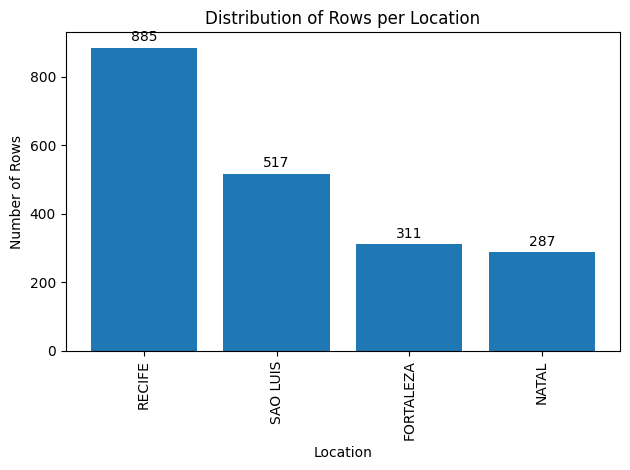

In [27]:
# Count the number of rows per location
location_counts = df['location'].value_counts()

# Create a bar chart
plt.bar(location_counts.index, location_counts.values)
plt.xlabel('Location')
plt.ylabel('Number of Rows')
plt.title('Distribution of Rows per Location')
plt.xticks(rotation=90)  # Rotate x-axis labels for better visibility

# Add text labels inside the bars
for i, count in enumerate(location_counts.values):
    plt.text(i, count + 10, str(count), ha='center', va='bottom', fontsize=10)

plt.tight_layout()

# Show the plot
plt.show()


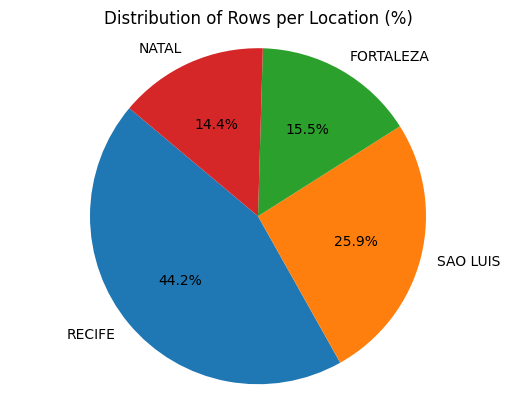

In [29]:
# Count the number of rows per location
location_counts = df['location'].value_counts()

# Create a pie chart
plt.pie(location_counts, labels=location_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Rows per Location (%)')

# Equal aspect ratio ensures that pie is drawn as a circle.
plt.axis('equal')

# Show the plot
plt.show()

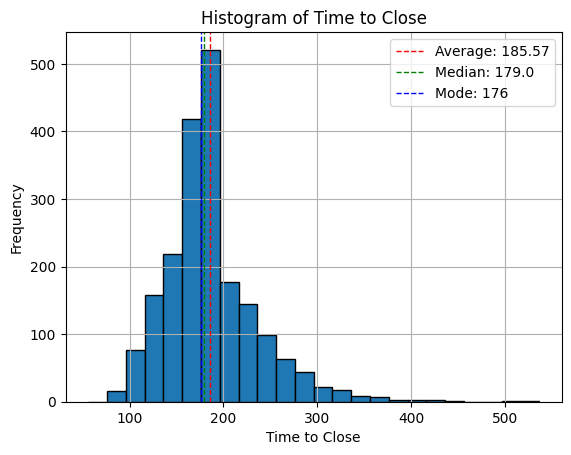

In [25]:
## Lets plot some graphics to understand the data:

ttc_min = df['time_to_close'].min()
ttc_max = df['time_to_close'].max()


plt.hist(df['time_to_close'], bins=np.arange(ttc_min-20, ttc_max+20, 20), edgecolor='black')
plt.xlabel('Time to Close')
plt.ylabel('Frequency')
plt.title('Histogram of Time to Close')
plt.grid(True)

# Calculate average, median, and mode
average = df['time_to_close'].mean()
median = df['time_to_close'].median()
mode = df['time_to_close'].mode()[0]

# Add lines for average, median, and mode
plt.axvline(average, color='r', linestyle='dashed', linewidth=1, label=f'Average: {average:.2f}')
plt.axvline(median, color='g', linestyle='dashed', linewidth=1, label=f'Median: {median}')
plt.axvline(mode, color='b', linestyle='dashed', linewidth=1, label=f'Mode: {mode}')
plt.legend()

# Show the plot
plt.show()

<Figure size 1000x600 with 0 Axes>

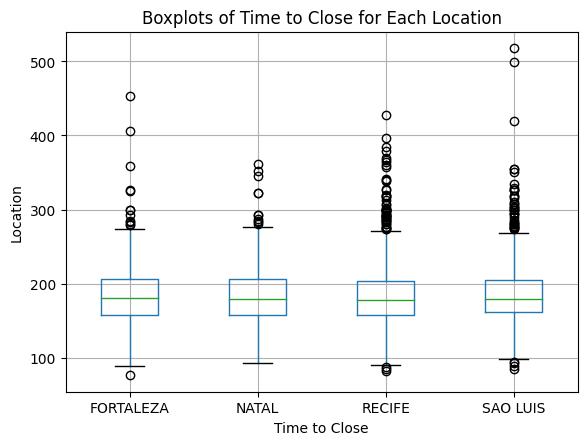

In [31]:
# Create boxplots for time_to_close for each location
plt.figure(figsize=(10, 6))  # Adjust the figure size if needed
df.boxplot(column='time_to_close', by='location', vert=True)
plt.xlabel('Time to Close')
plt.ylabel('Location')
plt.title('Boxplots of Time to Close for Each Location')
plt.suptitle('')  # Remove the default title added by pandas

# Show the plot
plt.show()